In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['text.usetex'] = False
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
from scipy.stats import chi2

from shapkit.shapley_values import ShapleyValues
from shapkit.inspector import inspector
from shapkit.monte_carlo_shapley import MonteCarloShapley
from shapkit.sgd_shapley import SGDshapley

%load_ext autoreload
%autoreload 2

# Generate dataset

In [45]:
d, n_samples = 16, 1000
mu = np.zeros(d)
Sigma = np.zeros((d,d))
np.fill_diagonal(Sigma, [1] * d)
X = np.random.multivariate_normal(mean=mu, cov=Sigma, size=n_samples)
X = pd.DataFrame(X, columns=['x'+str(i) for i in range(1, d+1)])
def fc(x):
    phi_x = np.sqrt(.5 * np.pi) * np.exp(-0.5 * x ** 2)
    return np.prod(phi_x)
y = np.zeros(len(X))
for i in range(len(X)):
    y[i] = fc(X.values[i])
n = 2**d - 2
print("dimension = {0} ; nb of coalitions = {1}".format(str(d), str(n)))

dimension = 16 ; nb of coalitions = 65534


# Experiments 

## Start computation

In [46]:
%%time

# n_iter = 2000 * d # nb of reward calls
# n_expe = 50

n_iter = 30000 # nb of reward calls
n_expe = 1
dict_results = {"MC": np.empty((n_expe, int(n_iter/d))),
                "cst step 0.01": np.empty((n_expe, int(n_iter/d))),
                "sqrt step 0.1": np.empty((n_expe, int(n_iter/d)))}

for i in range(n_expe):
    print()
    print("Expe n°"+str(i))
    # set the game
    idx_r, idx_x = np.random.choice(np.arange(len(X)), size=2, replace=False)
    r = X.iloc[idx_r,:]
    x = X.iloc[idx_x,:]

    # true Shapley Values
    if d <= 20:
        true_shap = ShapleyValues(x=x, fc=fc, ref=r)
    else:
        true_shap = MonteCarloShapley(x=x, fc=fc, ref=r, n_iter=100*d)
    print("True Shapley ✓")

    # Monte Carlo estimation
    mc_inspector = inspector(x_min=true_shap, verbose=False)
    mc_shap = MonteCarloShapley(x=x, fc=fc, ref=r, n_iter=int(n_iter/d),
                                callback=mc_inspector)
    dict_results["MC"][i,:] = mc_inspector.err
    print("Monte Carlo Shapley ✓")

    # SGD estimations
    C = y.max()
    D = C * np.sqrt(d)
    d = len(x)
    sgd_shap = SGDshapley(d, C)
    parameters = {"cst step 0.01": {"step":0.01, "step_type":"constant"},
                  "sqrt step 0.1": {"step":0.1, "step_type":"sqrt"}}
    # Start calculation of all methods
    for method, param in parameters.items():
        sgd_inspector = inspector(x_min=true_shap, verbose=False)
        sgd_shap.sgd(x=x, fc=fc, r=r, n_iter=n_iter, step=param["step"],
                     step_type=param["step_type"], callback=sgd_inspector)
        dict_results[method][i,:] = sgd_inspector.err
        print(method + " ✓")

# Save results
# for method in dict_results.keys():
#     np.save("results_regression/dimension_16/new_results/"+method, dict_results[method])
# print()
# print("Saved ! ✓")

 12%|█▎        | 2/16 [00:00<00:00, 18.05it/s]


Expe n°0


  9%|▉         | 169/1875 [00:00<00:02, 849.47it/s]

True Shapley ✓


  2%|▏         | 545/30000 [00:00<00:05, 5443.84it/s]

Monte Carlo Shapley ✓


  2%|▏         | 477/30000 [00:00<00:06, 4767.31it/s]

cst step 0.01 ✓


100%|██████████| 30000/30000 [00:06<00:00, 4804.64it/s]

sqrt step 0.1 ✓
CPU times: user 2min 57s, sys: 107 ms, total: 2min 57s
Wall time: 2min 57s


## Load results stored (if needed)

methods = ["MC","cst step 0.01","sqrt step 0.1"]
dict_results = dict()
for method in methods:
    dict_results[method] = np.load("../results_regression/dimension_16/new_results/"+method+".npy")

# Plots

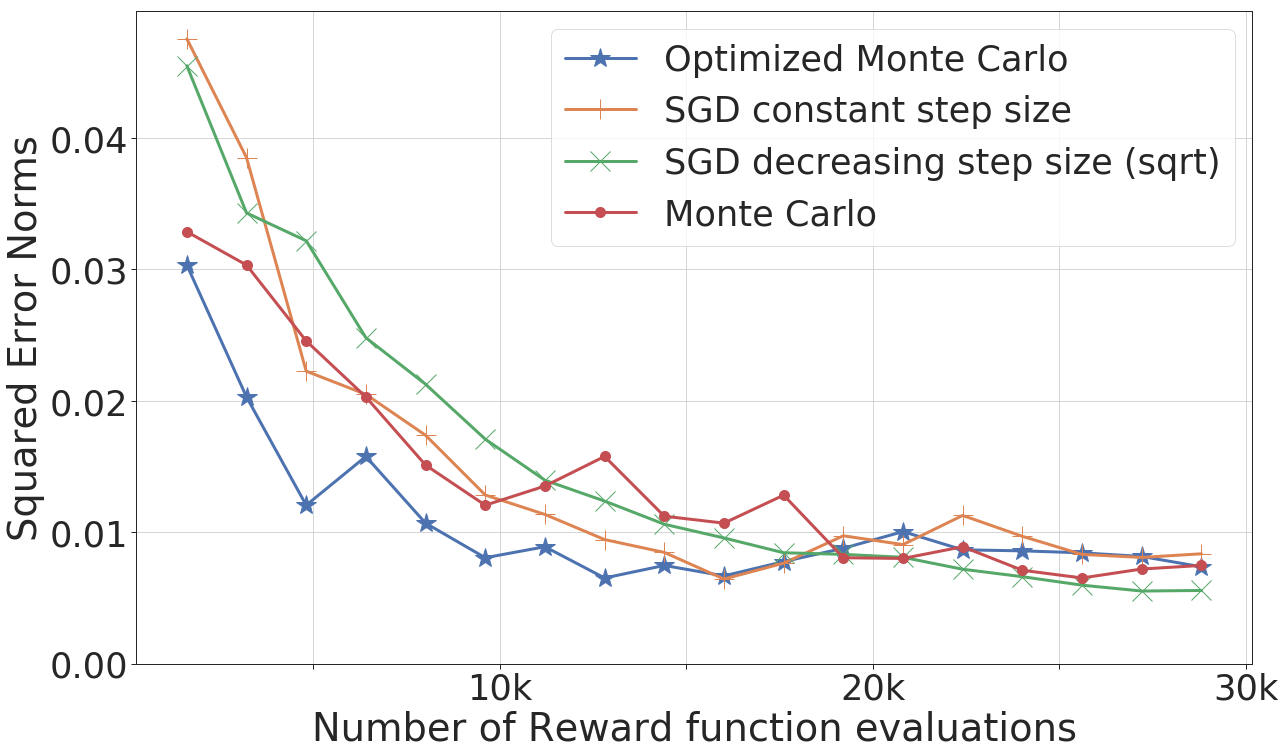

In [47]:
n_iter = dict_results["MC"].shape[1]

sns.set_style("ticks")
sns.set_context("paper", font_scale=4, rc={"lines.linewidth": 3})

plt.figure(figsize=(20,12))
import itertools
marker = itertools.cycle(('*', '+', 'x', '.', 'v'))

for method in dict_results.keys():
    # n_iter = dict_results[method].shape[1]
    idx = np.arange(100,n_iter,100)
    if method in ["MC","sqrt step 0.1","cst step 0.01"]:
        if method == "MC":
            label = "Optimized Monte Carlo"
        elif method == "sqrt step 0.1":
            label = "SGD decreasing step size (sqrt)"
        elif method == "cst step 0.01":
            label = "SGD constant step size"
        plt.plot(idx*d + d,
                 dict_results[method].mean(axis=0)[idx],
                 label=label,
                 marker=next(marker),
                 markersize=20)
# Classical MC
plt.plot(idx*d + d,
         dict_results["MC"].mean(axis=0)[idx // 2],
         label="Monte Carlo",
         marker=next(marker),
         markersize=20)
plt.xlabel("Number of Reward function evaluations")
# plt.xticks(idx*d + d)
# plt.xticks([(idx*d + d)[0]] + list(range(5000, 35000, 5000)))
plt.xticks(list(range(5000, 35000, 5000)), ["","10k", "","20k","", "30k"])
# plt.xscale('log')
plt.ylabel("Squared Error Norms")
plt.ylim(ymin=0)
# plt.yticks(np.arange(0,0.08,0.01), ["0.00", "", "0.02", "", "0.04", "", "0.06"])
plt.legend(loc='best')
plt.grid(True)
# plt.title("Regression - Dimension 16")
# plt.savefig("../results_regression/dimension_16/plots/results.png", format="png")
plt.show()